### Initial EDA

#### Started pmf visualization

In [123]:
import collections

# count the frequency of each price
counter = collections.Counter(df['price'])

In [124]:
# Convert frequency to probability - divide each frequency value by total number of values
pmf = []
for key,val in counter.items():
    pmf.append(val/df2.shape[0])

# price per oz of beers with frequency of these prices
print(counter.keys(), pmf)

dict_keys([8, 9]) [0.3125, 0.6875]


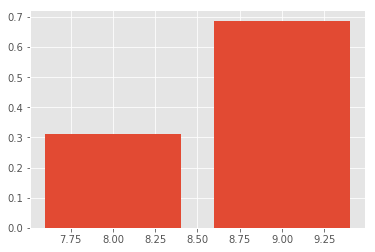

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(counter.keys(),pmf);

### Chi-square independence

#### Are certain beer styles more popular in each borough?

##### H0: Borough has no effect on the popularity of a beer style.

##### Ha: (Style) IPAs are more popular in (borough) Brooklyn.

In [62]:
boroughs = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']

In [69]:
for beer in counter.keys():
    if counter[beer] in styles.values():
        counter[beer] = styles[beer]
counter

Counter({'Pilsner': 1,
         'IPA': 3,
         'Cider': 2,
         'Lager': 1,
         'NE/Hazy IPA': 2,
         'Spiced Beer': 1,
         'Dry Stout': 1,
         'Witbier': 1,
         'Tripel': 1,
         'Porter': 1,
         'Pale Lager': 1,
         'Gose': 1})

In [16]:
# number of rows
r = len(styles.keys())
# columns
c = len(boroughs)
r,c
# calc degrees of freedom
df = (r-1)*(c-1)
df

36